<a href="https://colab.research.google.com/github/NitaiBanik/ProjectsFor/blob/master/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model

In [4]:
# imports for building the network
import tensorflow as tf
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [5]:
# Kernel Configurations
make_submission = False # used to turn off lengthy model analysis so a submission version doesn't run into memory error
load_pretrained_model = True # load a pre-trained model
save_model = True # save the model after training
train_dir = '/content/drive/My Drive/Colab/' # directory of training images
pretrained_model_path = '/content/drive/My Drive/Colab_Model/model_st.h5' # path of pretrained model
model_save_path = './ResUNetSteel30_w800e50_z.h5' # path of model to save
#train_image_dir = os.path.join(train_dir, 'train') # 
train_image_dir = '/content/drive/My Drive/Colab/train_2/train'

In [6]:
# network configuration parameters
# original image is 1600x256, so we will resize it
img_w = 800 # resized weidth
img_h = 256 # resized height
batch_size = 12
epochs = 25
# batch size for training unet
k_size = 3 # kernel size 3x3
val_size = .20 # split of training set between train and validation set
# we will repeat the images with lower samples to make the training process more fair
repeat = False
# only valid if repeat is True
class_1_repeat = 1 # repeat class 1 examples x times
class_2_repeat = 1
class_3_repeat = 1
class_4_repeat = 1

In [7]:
# load full data and label no mask as -1
#train_df = pd.read_csv(os.path.join(train_dir, '/content/drive/My Drive/Colab/100.csv')).fillna(-1)
train_df = pd.read_csv('/content/drive/My Drive/Colab/train.csv').fillna(-1)
# image id and class id are two seperate entities and it makes it easier to split them up in two columns

In [8]:
# image id and class id are two seperate entities and it makes it easier to split them up in two columns
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
# lets create a dict with class id and encoded pixels and group all the defaults per image
train_df['ClassId_EncodedPixels'] = train_df.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)
grouped_EncodedPixels = train_df.groupby('ImageId')['ClassId_EncodedPixels'].apply(list)

In [9]:
# from https://www.kaggle.com/robertkag/rle-to-mask-converter
def rle_to_mask(rle_string,height,width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rleString (str): Description of arg1 
    height (int): height of the mask
    width (int): width of the mask 

    Returns: 
    numpy.array: numpy array of the mask
    '''
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rleNumbers = [int(numstring) for numstring in rle_string.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols,dtype=np.uint8)
        for index,length in rlePairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

In [10]:
# Thanks to the authors of: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask_to_rle(mask):
    '''
    Convert a mask into RLE
    
    Parameters: 
    mask (numpy.array): binary mask of numpy array where 1 - mask, 0 - background

    Returns: 
    sring: run length encoding 
    '''
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [11]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
                 img_h=256, img_w=512, shuffle=True):
        
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 4))
        
        for idx, id in enumerate(list_ids_temp):
            file_path =  os.path.join(self.image_dir, id)
            image = cv2.imread(file_path, 0)
            image_resized = cv2.resize(image, (self.img_w, self.img_h))
            image_resized = np.array(image_resized, dtype=np.float64)
            # standardization of the image
            image_resized -= image_resized.mean()
            image_resized /= image_resized.std()
            
            mask = np.empty((img_h, img_w, 4))
            
            for idm, image_class in enumerate(['1','2','3','4']):
                rle = self.labels.get(id + '_' + image_class)
                # if there is no mask create empty mask
                if rle is None:
                    class_mask = np.zeros((1600, 256))
                else:
                    class_mask = rle_to_mask(rle, width=1600, height=256)
             
                class_mask_resized = cv2.resize(class_mask, (self.img_w, self.img_h))
                mask[...,idm] = class_mask_resized
            
            X[idx,] = np.expand_dims(image_resized, axis=2)
            y[idx,] = mask
        
        # normalize Y
        y = (y > 0).astype(float)
            
        return X, y

In [12]:
# create a dict of all the masks
masks = {}
for index, row in train_df[train_df['EncodedPixels']!=-1].iterrows():
    masks[row['ImageId_ClassId']] = row['EncodedPixels']

In [13]:
if repeat:
    class_1_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='1')]['ImageId'].values
    class_1_img_id = np.repeat(class_1_img_id, class_1_repeat)
    class_2_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='2')]['ImageId'].values
    class_2_img_id = np.repeat(class_2_img_id, class_2_repeat)
    class_3_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='3')]['ImageId'].values
    class_3_img_id = np.repeat(class_3_img_id, class_3_repeat)
    class_4_img_id = train_df[(train_df['EncodedPixels']!=-1) & (train_df['ClassId']=='4')]['ImageId'].values
    class_4_img_id = np.repeat(class_4_img_id, class_4_repeat)
    train_image_ids = np.concatenate([class_1_img_id, class_2_img_id, class_3_img_id, class_4_img_id])
else:
    # split the training data into train and validation set (stratified)
    train_image_ids = train_df['ImageId'].unique()

In [14]:
X_train, X_val = train_test_split(train_image_ids, test_size=val_size, random_state=42)

In [15]:
params = {'img_h': img_h,
          'img_w': img_w,
          'image_dir': train_image_dir,
          'batch_size': batch_size,
          'shuffle': True}

# Get Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)

In [17]:
# check out the shapes
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)
print(type(y))

(12, 256, 800, 1) (12, 256, 800, 4)
<class 'numpy.ndarray'>


In [18]:
# visualize steel image with four classes of faults in seperate columns
def viz_steel_img_mask(img, masks):
    img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20,10))
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    for idx, mask in enumerate(masks):
        ax[idx].imshow(img)
        ax[idx].imshow(mask, alpha=0.3, cmap=cmaps[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

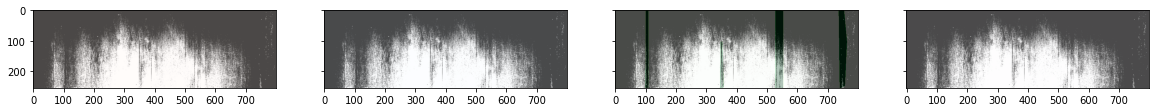

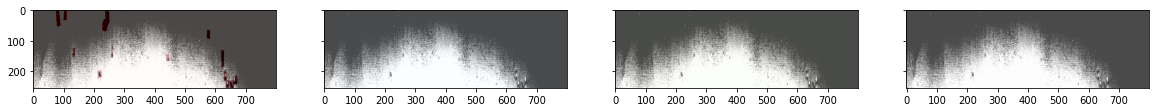

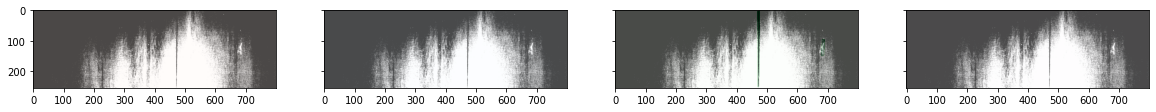

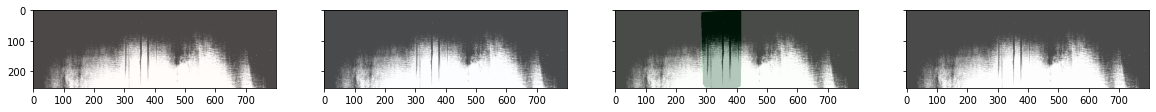

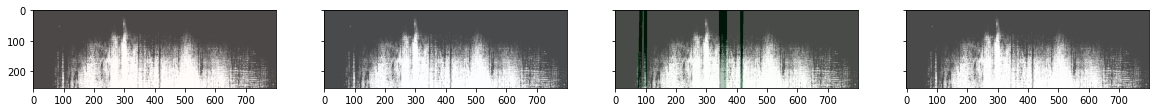

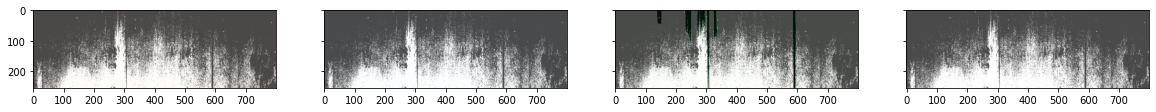

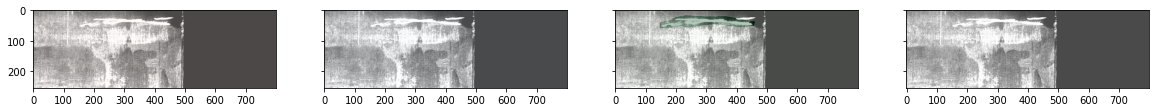

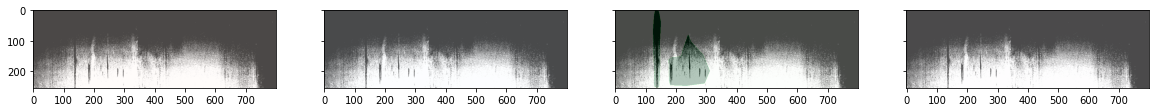

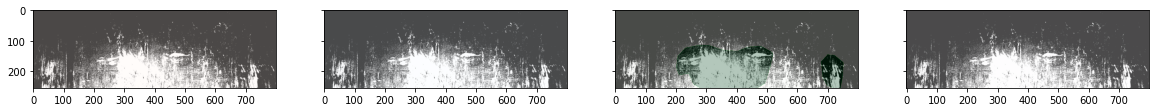

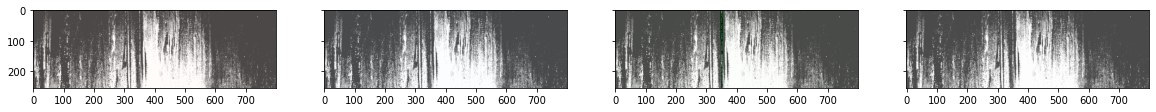

In [19]:
for ix in range(0,batch_size):
    if y[ix].sum() > 0:
        img = x[ix]
        masks_temp = [y[ix][...,i] for i in range(0,4)]
        viz_steel_img_mask(img, masks_temp)

In [20]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x

In [21]:
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

In [22]:
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output

In [23]:
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output

In [24]:
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c

In [27]:
def ResUNet(img_h, img_w):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [29]:
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [30]:
# Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

In [31]:
model = ResUNet(img_h=img_h, img_w=img_w)
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=[tversky])

In [32]:
if load_pretrained_model:
    try:
        model.load_weights(pretrained_model_path)
        print('pre-trained model loaded!')
    except OSError:
        print('You need to run the model and load the trained model')

pre-trained model loaded!


In [33]:
history = model.fit(training_generator, validation_data=validation_generator, epochs=epochs, verbose=1)

Epoch 1/25
837/837 [==============================] - 3811s 5s/step - loss: 0.3467 - tversky: 0.7403 - val_loss: 0.5356 - val_tversky: 0.5564
Epoch 2/25
837/837 [==============================] - 1087s 1s/step - loss: 0.3323 - tversky: 0.7556 - val_loss: 0.5440 - val_tversky: 0.5466
Epoch 3/25
837/837 [==============================] - 1086s 1s/step - loss: 0.3426 - tversky: 0.7445 - val_loss: 0.5587 - val_tversky: 0.5309
Epoch 4/25
837/837 [==============================] - 1086s 1s/step - loss: 0.3401 - tversky: 0.7466 - val_loss: 0.5377 - val_tversky: 0.5535
Epoch 5/25
837/837 [==============================] - 1086s 1s/step - loss: 0.3372 - tversky: 0.7507 - val_loss: 0.5680 - val_tversky: 0.5207
Epoch 6/25
837/837 [==============================] - 1084s 1s/step - loss: 0.3405 - tversky: 0.7466 - val_loss: 0.5626 - val_tversky: 0.5266
Epoch 7/25
837/837 [==============================] - 1087s 1s/step - loss: 0.3370 - tversky: 0.7500 - val_loss: 0.5495 - val_tversky: 0.5413
Epoch 

In [41]:
def get_test_tensor(img_dir, img_h, img_w, channels=1):

    X = np.empty((1, img_h, img_w, channels))
    # Store sample
    image = cv2.imread(img_dir, 0)
    image_resized = cv2.resize(image, (img_w, img_h))
    image_resized = np.array(image_resized, dtype=np.float64)
    # normalize image
    image_resized -= image_resized.mean()
    image_resized /= image_resized.std()
    
    X[0,] = np.expand_dims(image_resized, axis=2)

    return X

In [44]:
from skimage import morphology

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [45]:
import glob
# get all files using glob
test_files = [f for f in glob.glob('/content/drive/My Drive/Colab/Test_Images/' + "*.jpg", recursive=True)]

In [47]:
submission = []

# a function to apply all the processing steps necessery to each of the individual masks
def process_pred_mask(pred_mask):
    
    pred_mask = cv2.resize(pred_mask.astype('float32'),(1600, 256))
    pred_mask = (pred_mask > .5).astype(int)
    pred_mask = remove_small_regions(pred_mask, 0.02 * np.prod(512)) * 255
    pred_mask = mask_to_rle(pred_mask)
    
    return pred_mask

# loop over all the test images
for f in test_files:
    # get test tensor, output is in shape: (1, 256, 512, 3)
    test = get_test_tensor(f, img_h, img_w) 
    # get prediction, output is in shape: (1, 256, 512, 4)
    pred_masks = model.predict(test) 
    # get a list of masks with shape: 256, 512
    pred_masks = [pred_masks[0][...,i] for i in range(0,4)]
    # apply all the processing steps to each of the mask
    pred_masks = [process_pred_mask(pred_mask) for pred_mask in pred_masks]
    # get our image id
    id = f.split('/')[-1]
    # create ImageId_ClassId and get the EncodedPixels for the class ID, and append to our submissions list
    [submission.append((id+'_%s' % (k+1), pred_mask)) for k, pred_mask in enumerate(pred_masks)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  """


In [48]:
for item in submission:
 print(item)

('00b7fb703.jpg_1', '')
('00b7fb703.jpg_2', '')
('00b7fb703.jpg_3', '23503 1 23759 1 24015 1 25807 8 25823 2 26063 8 26079 3 26318 49 26574 49 26807 72 27063 73 27304 89 27560 89 27815 90 28071 90 28326 91 28582 91 28838 91 29093 92 29349 92 29605 92 29861 92 30117 92 30373 92 30629 92 30885 92 31141 92 31397 92 31653 92 31909 92 32166 91 32421 92 32678 91 32934 91 33190 91 33448 89 33704 89 33964 85 34221 84 34479 82 34737 80 34995 78 35251 78 35508 76 35764 76 36025 70 36281 42 36324 27 36539 36 36590 15 36795 18 36814 17 36847 14 37052 15 37070 9 37080 5 37103 2 37107 9 37308 14 37326 9 37339 1 37359 2 37364 8 37564 11 37582 9 37622 5 37821 7 37829 1 37838 9 37879 4 38077 6 38094 8 38135 4 38333 6 38350 8 38391 4 38589 6 38606 9 38647 4 38846 5 38862 9 38903 4 39103 4 39115 12 39161 3 39359 4 39371 12 39417 3 39617 2 39627 12 39673 4 39679 1 39873 2 39883 12 39929 4 39935 1 40140 11 40191 2 40395 12 40447 2 40651 12 40703 2 40906 13 40959 2 41161 14 41215 2 41417 14 41471 2 41672 15